In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import datetime

In [2]:
file_path_volts1 = r".\dataset\H1\Tagged_Training_04_13_1334300401\LF1V.csv"
file_path_amps1 = r".\dataset\H1\Tagged_Training_04_13_1334300401\LF1I.csv"
file_path_time_ticks1 = r".\dataset\H1\Tagged_Training_04_13_1334300401\TimeTicks1.csv"

file_path_volts2 = r".\dataset\H1\Tagged_Training_04_13_1334300401\LF1V.csv"
file_path_amps2 = r".\dataset\H1\Tagged_Training_04_13_1334300401\LF1I.csv"
file_path_time_ticks2 = r".\dataset\H1\Tagged_Training_04_13_1334300401\TimeTicks1.csv"

LF1V = pd.read_csv(file_path_volts1)
LF1I = pd.read_csv(file_path_amps1)
time_ticks1 = pd.read_csv(file_path_time_ticks1)

LF2V = pd.read_csv(file_path_volts2)
LF2I = pd.read_csv(file_path_amps2)
time_ticks2 = pd.read_csv(file_path_time_ticks2)

In [3]:
LF1V = np.array(LF1V)
LF1I = np.array(LF1I)
LF1V = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF1V])
LF1I = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF1I])

LF2V = np.array(LF2V)
LF2I = np.array(LF2I)
LF2V = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF2V])
LF2I = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF2I])

In [17]:
L1_P = LF1V * np.conjugate(LF1I)
L2_P = LF2V * np.conjugate(LF2I)

L1_ComplexPower = np.sum(L1_P, axis=1)
L2_ComplexPower = np.sum(L2_P, axis=1)

L1_real = np.real(L1_ComplexPower)
L1_imag = np.imag(L1_ComplexPower)
L1_app = np.abs(L1_ComplexPower)

L2_real = np.real(L2_ComplexPower)
L2_imag = np.imag(L2_ComplexPower)
L2_app = np.abs(L2_ComplexPower)

L1_Pf = np.cos(np.angle(L1_P[:, 0]))
L2_Pf = np.cos(np.angle(L2_P[:, 0]))

L1_actual_power = L1_real * L1_Pf
L2_actual_power = L2_real * L2_Pf

power = L1_actual_power + L2_actual_power

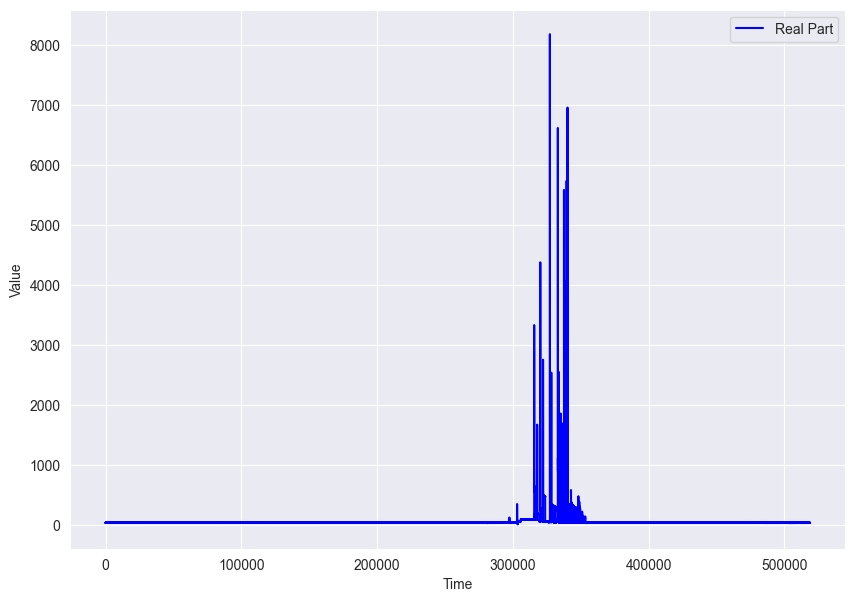

In [18]:
plt.figure(figsize=(10, 7))
plt.plot(range(len(time_ticks2)), L1_app, linestyle='-', color='b', label='Real Part')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()